In [44]:
import warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from pathlib import Path
import subprocess
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_fscore_support, classification_report
)

warnings.filterwarnings("ignore")

# Cargue de base de datos

In [2]:
# Importando datos

ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

DATA_DIR = ROOT / "data" / "raw"
assert DATA_DIR.exists(), f"No existe la carpeta {DATA_DIR}. Crea data/raw y coloca el Excel allí."

cands = list(DATA_DIR.glob("Online*Retail*.xls*"))
if not cands:
    raise FileNotFoundError(
        "No se encontró ningún archivo tipo 'Online*Retail*.xls*' en data/raw.\n"
        "Asegúrate de copiar el archivo (por ej. 'Online Retail.xlsx') a data/raw."
    )
fp = cands[0]
print(f"Archivo detectado: {fp}")

# ---- Lectura robusta (instala openpyxl si hace falta para .xlsx) ----
def read_excel_safely(path: Path) -> pd.DataFrame:
    if path.suffix.lower() == ".xlsx":
        try:
            import openpyxl  # noqa
        except ImportError:
            print("Instalando 'openpyxl' para leer .xlsx…")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "openpyxl"])
    return pd.read_excel(path)

df = read_excel_safely(fp)

Archivo detectado: c:\Users\usuari\documents\repo\ProyectoFinalMLOps\data\raw\Online Retail.xlsx


# EDA (Exploratory Data Analysis)

### Muestra dataset

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


### Resumen Dataset

In [9]:
df.info

<bound method DataFrame.info of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  Cust

### Medidas descriptivas

In [28]:

df.describe().T


,count,mean,min,25%,50%,75%,max,std
Quantity,397884.0,12.988238,1.0,2.0,6.0,12.0,80995.0,179.331775
InvoiceDate,397884,2011-07-10 23:41:23.511023360,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
UnitPrice,397884.0,3.116488,0.001,1.25,1.95,3.75,8142.75,22.097877
CustomerID,397884.0,15294.423453,12346.0,13969.0,15159.0,16795.0,18287.0,1713.14156
Revenue,397884.0,22.397,0.001,4.68,11.8,19.8,168469.6,309.071041


### Tipos de variables dataset

In [31]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
Revenue               float64
dtype: object

In [30]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Revenue'],
      dtype='object')

### Nivel de recompra actual

In [73]:
# convertir a datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# ordenar por cliente y fecha
df = df.sort_values(by=['CustomerID', 'InvoiceDate'])

# calcular diferencia entre compras
df['days_between'] = df.groupby('CustomerID')['InvoiceDate'].diff().dt.days

# filtrar recompras menores a 30 días
recompras_30 = df[(df['days_between'] > 0) & (df['days_between'] < 30)]

# ---- MÉTRICAS ----
total_recompras = recompras_30.shape[0]
promedio_dias = recompras_30['days_between'].mean()
mediana_dias = recompras_30['days_between'].median()
min_dias = recompras_30['days_between'].min()
max_dias = recompras_30['days_between'].max()

# métricas por cliente
recompras_cliente = (
    recompras_30.groupby('CustomerID')
    .agg(
        total_recompras=('days_between', 'count'),
        promedio_dias=('days_between', 'mean'),
        mediana_dias=('days_between', 'median'),
        min_dias=('days_between', 'min'),
        max_dias=('days_between', 'max')
    )
    .reset_index()
)

# porcentaje de clientes que recompran
clientes_con_recompra = recompras_cliente['CustomerID'].nunique()
clientes_totales = df['CustomerID'].nunique()
porcentaje_clientes = (clientes_con_recompra / clientes_totales) * 100

# top clientes con más recompras
top_clientes = recompras_cliente.sort_values(by='total_recompras', ascending=False).head(10)

# clientes que nunca recompran
clientes_sin_recompra = clientes_totales - clientes_con_recompra

# ---- RESULTADOS ----
print("👉 Total de recompras (1–30 días):", total_recompras)
print("👉 Promedio de días entre recompras:", round(promedio_dias, 2))
print("👉 Mediana de días entre recompras:", mediana_dias)
print("👉 Mínimo de días entre recompras:", min_dias)
print("👉 Máximo de días entre recompras (<30):", max_dias)
print("👉 Clientes que recompran en <30 días:", clientes_con_recompra)
print("👉 Clientes que no recompran en <30 días:", clientes_sin_recompra)
print("👉 Total de clientes:", clientes_totales)
print(f"👉 % de clientes con recompra <30 días: {porcentaje_clientes:.2f}%")

print("\n👉 Top 10 clientes con más recompras:")
print(top_clientes)


👉 Total de recompras (1–30 días): 6372
👉 Promedio de días entre recompras: 13.04
👉 Mediana de días entre recompras: 12.0
👉 Mínimo de días entre recompras: 1.0
👉 Máximo de días entre recompras (<30): 29.0
👉 Clientes que recompran en <30 días: 1453
👉 Clientes que no recompran en <30 días: 2885
👉 Total de clientes: 4338
👉 % de clientes con recompra <30 días: 33.49%

👉 Top 10 clientes con más recompras:
      CustomerID  total_recompras  promedio_dias  mediana_dias  min_dias  \
1355       17841              109       2.880734           3.0       1.0   
646        14911               93       3.161290           2.0       1.0   
733        15311               87       3.712644           3.0       1.0   
560        14606               87       3.781609           4.0       1.0   
108        12748               79       3.392405           3.0       1.0   
157        12971               66       5.045455           4.0       1.0   
181        13089               61       5.459016           4.0   

In [32]:
# Limpieza y clasificación de datos
df["InvoiceNo"] = df["InvoiceNo"].astype(str)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])

# Filtrado básico para el MVP de recompra - Elimina todo lo que no representa compras positivas
df = df[(df["UnitPrice"] > 0) & (df["Quantity"] > 0)]
df = df[~df["InvoiceNo"].str.startswith("C")]      # fuera devoluciones/cancelaciones

# Limpieza para trabajar con clientes identificables
df = df.dropna(subset=["CustomerID"]).copy()
df["CustomerID"] = df["CustomerID"].astype(int)

# Totalizando compras
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

In [11]:
# 01 - Información base
print("Fecha mínima:", df["InvoiceDate"].min())
print("Fecha máxima:", df["InvoiceDate"].max())
print("Clientes únicos:", df["CustomerID"].nunique())
print("SKUs únicos:", df["StockCode"].nunique())
print("Países:", df["Country"].nunique())
print(f"Rango de fechas: {df['InvoiceDate'].min().date()} → {df['InvoiceDate'].max().date()}")

# Ventas por día
daily = df.set_index("InvoiceDate").resample("D")["Revenue"].sum().reset_index()
daily.head()

Fecha mínima: 2010-12-01 08:26:00
Fecha máxima: 2011-12-09 12:50:00
Clientes únicos: 4338
SKUs únicos: 3665
Países: 37
Rango de fechas: 2010-12-01 → 2011-12-09


,InvoiceDate,Revenue
0,2010-12-01,46376.49
1,2010-12-02,47316.53
2,2010-12-03,23921.71
3,2010-12-04,0.00
4,2010-12-05,31771.60


# Analisis grafico

### Distribución de variables

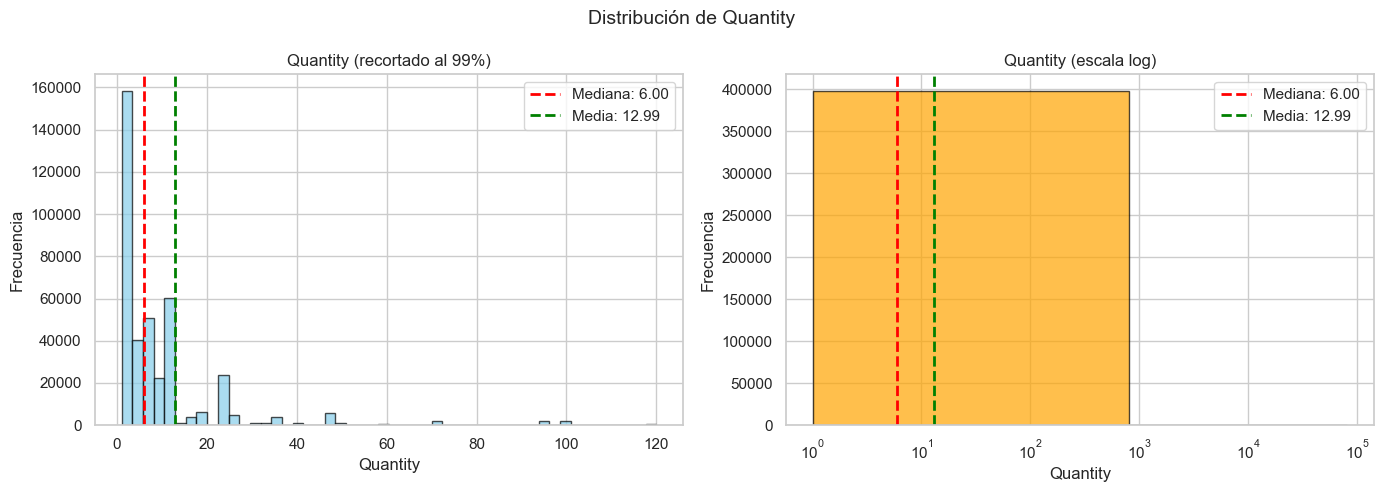

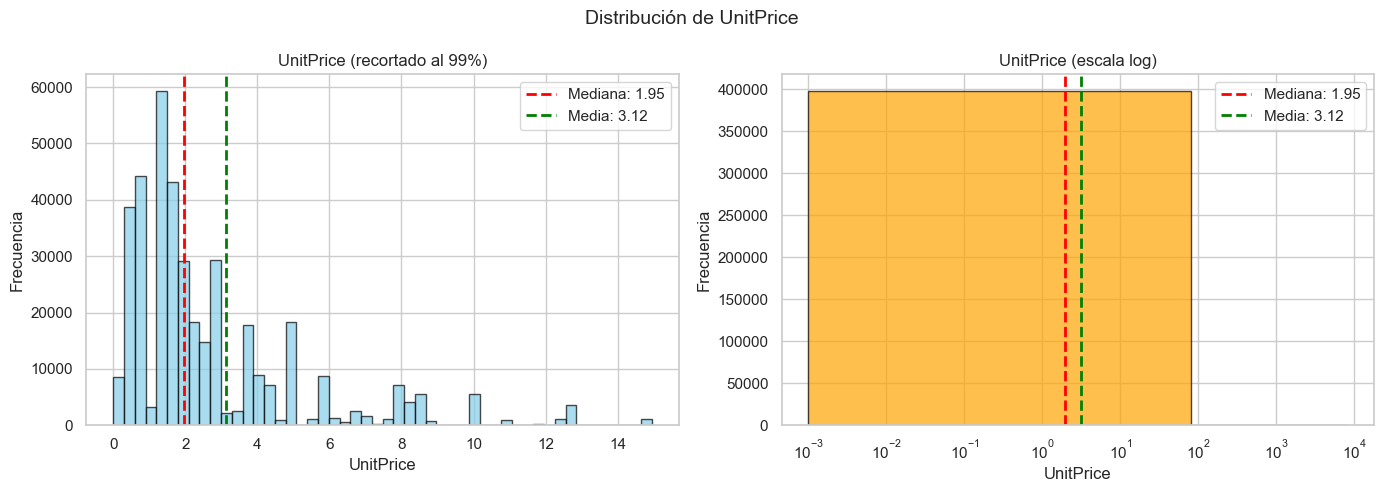

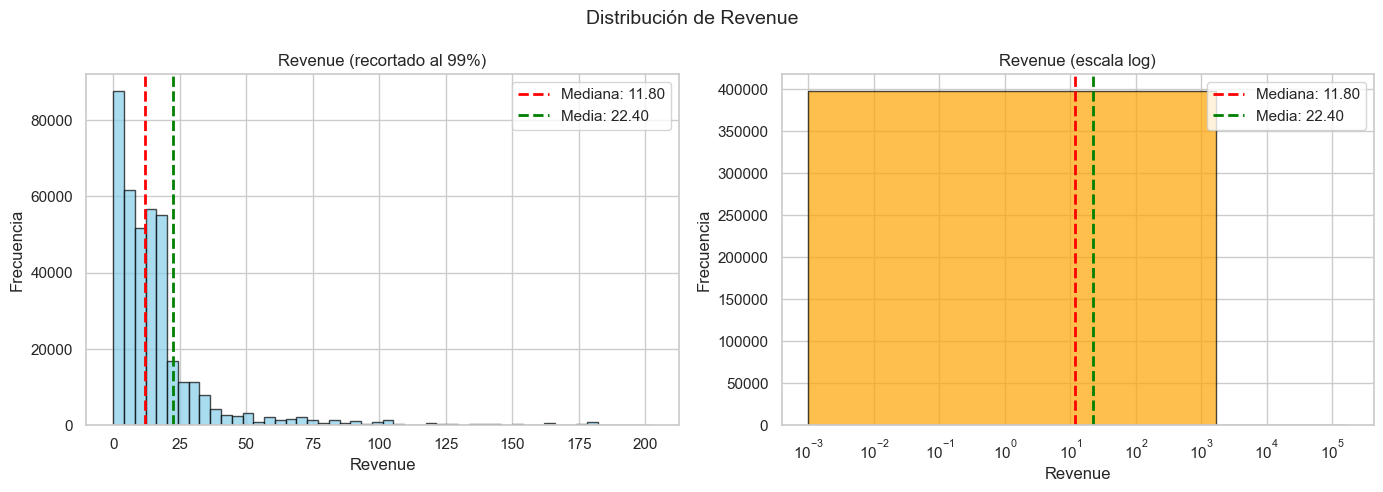

In [61]:
import matplotlib.pyplot as plt

# Variables numéricas a graficar
num_cols = ['Quantity', 'UnitPrice', 'Revenue']

for col in num_cols:
    median = df[col].median()
    mean = df[col].mean()
    
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    
    # --- Histograma recortado al 99% ---
    axes[0].hist(df[col][df[col] <= df[col].quantile(0.99)], bins=50,
                 color="skyblue", edgecolor="black", alpha=0.7)
    axes[0].axvline(median, color="red", linestyle="--", linewidth=2, label=f"Mediana: {median:.2f}")
    axes[0].axvline(mean, color="green", linestyle="--", linewidth=2, label=f"Media: {mean:.2f}")
    axes[0].set_title(f"{col} (recortado al 99%)")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frecuencia")
    axes[0].legend()
    
    # --- Histograma con escala log ---
    axes[1].hist(df[col], bins=100, color="orange", edgecolor="black", alpha=0.7)
    axes[1].axvline(median, color="red", linestyle="--", linewidth=2, label=f"Mediana: {median:.2f}")
    axes[1].axvline(mean, color="green", linestyle="--", linewidth=2, label=f"Media: {mean:.2f}")
    axes[1].set_xscale("log")
    axes[1].set_title(f"{col} (escala log)")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Frecuencia")
    axes[1].legend()
    
    plt.suptitle(f"Distribución de {col}", fontsize=14)
    plt.tight_layout()
    plt.show()




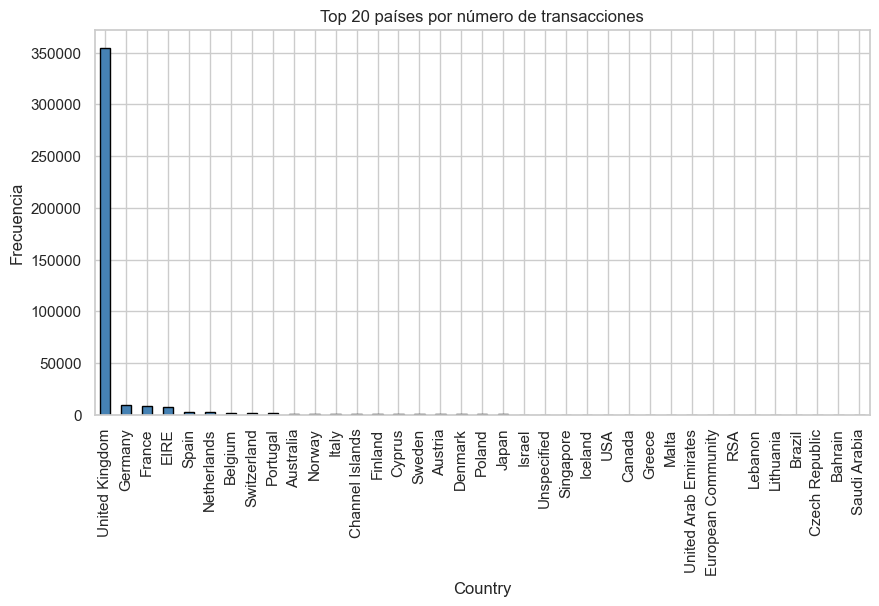

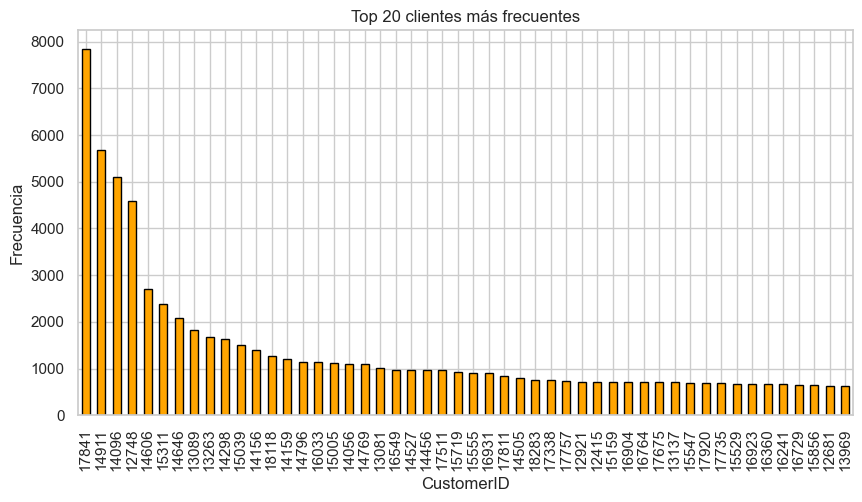

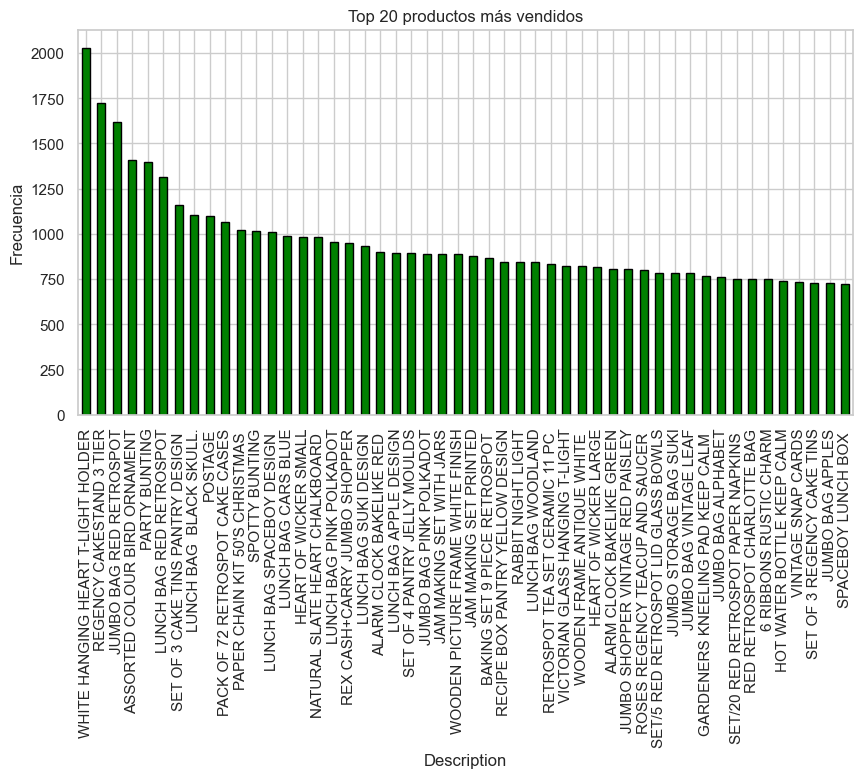

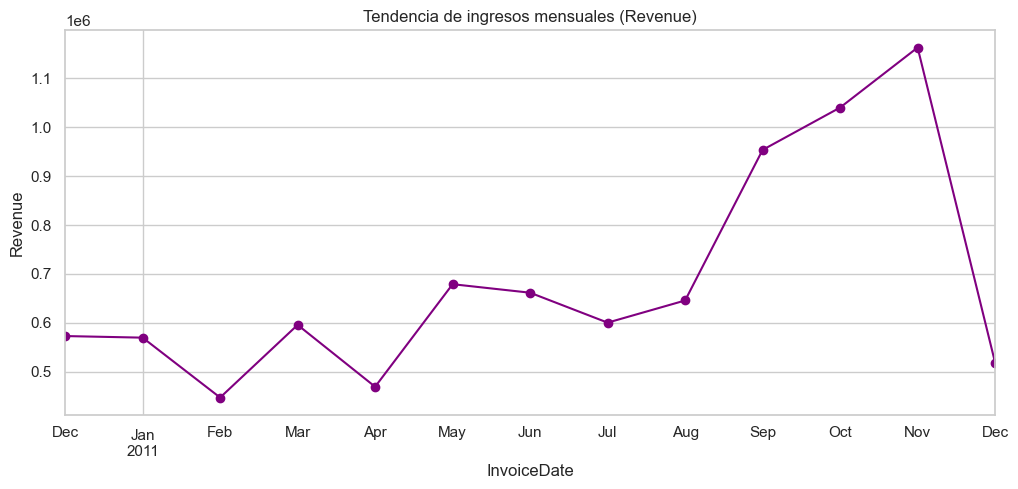

In [74]:

# -------------------------------

# Países con más transacciones
plt.figure(figsize=(10,5))
df['Country'].value_counts().head(50).plot(kind='bar', color="steelblue", edgecolor="black")
plt.title("Top 20 países por número de transacciones")
plt.ylabel("Frecuencia")
plt.show()

# Clientes más frecuentes
plt.figure(figsize=(10,5))
df['CustomerID'].value_counts().head(50).plot(kind='bar', color="orange", edgecolor="black")
plt.title("Top 20 clientes más frecuentes")
plt.ylabel("Frecuencia")
plt.show()

# Productos más vendidos
plt.figure(figsize=(10,5))
df['Description'].value_counts().head(50).plot(kind='bar', color="green", edgecolor="black")
plt.title("Top 20 productos más vendidos")
plt.ylabel("Frecuencia")
plt.show()

# -------------------------------
# 4. Análisis temporal
# -------------------------------
# Ventas por mes
df.set_index('InvoiceDate').resample('M')['Revenue'].sum().plot(figsize=(12,5), marker='o', color="purple")
plt.title("Tendencia de ingresos mensuales (Revenue)")
plt.ylabel("Revenue")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Fases y sub-actividades
fases = {
    "Diagnóstico inicial (Oct 2025)": [
        "Reunión con stakeholders",
        "Revisión de bases de datos",
        "Definición de objetivos de negocio"
    ],
    "Desarrollo de la solución analítica (Nov–Dic 2025)": [
        "Limpieza y preparación de datos",
        "Análisis exploratorio (EDA)",
        "Feature engineering",
        "Entrenamiento y validación del modelo",
        "Dashboard de resultados"
    ],
    "Intervenciones estratégicas (Ene 2026)": [
        "Integración del modelo a marketing/ventas",
        "Campañas personalizadas",
        "Medición del impacto (ROI)",
        "Entrega final ejecutiva"
    ]
}

# Colores
colores = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))

y_pos = 0
for idx, (fase, actividades) in enumerate(fases.items()):
    # Barra principal de la fase
    ax.barh(y_pos, len(actividades), left=0, color=colores[idx], height=0.5)
    ax.text(len(actividades)/2, y_pos, fase, ha='center', va='center', color="white", fontsize=10, fontweight="bold")
    
    # Sub-actividades
    for j, act in enumerate(actividades):
        y_pos -= 1
        ax.barh(y_pos, 1, left=j, color=colores[idx], alpha=0



SyntaxError: '(' was never closed (1316477853.py, line 40)

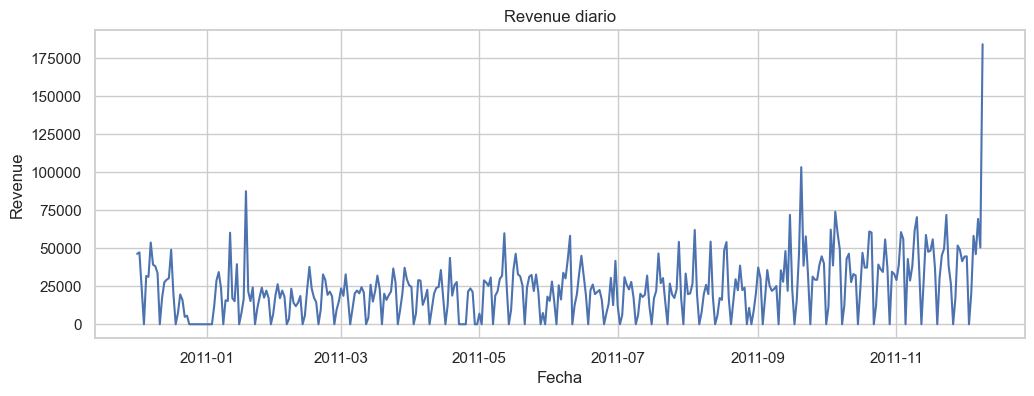

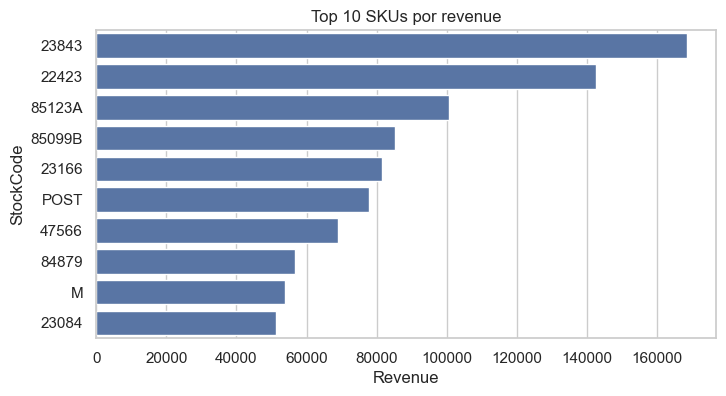

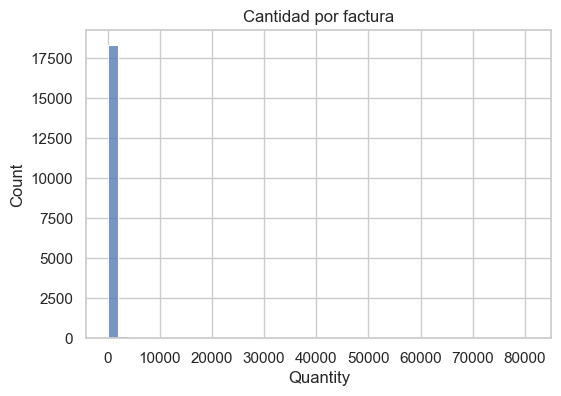

In [68]:
# 02 - Gráficos básicos (matplotlib / seaborn)

# Serie de ventas diarias
plt.figure(figsize=(12,4))
plt.plot(daily["InvoiceDate"], daily["Revenue"])
plt.title("Revenue diario")
plt.xlabel("Fecha"); plt.ylabel("Revenue")
plt.show()

# Top 10 productos por revenue
top_skus = (df.groupby("StockCode")["Revenue"].sum()
              .sort_values(ascending=False).head(10).reset_index())

plt.figure(figsize=(8,4))
sns.barplot(data=top_skus, x="Revenue", y="StockCode")
plt.title("Top 10 SKUs por revenue")
plt.show()

# Distribución de cantidad por factura
qty_per_invoice = df.groupby("InvoiceNo")["Quantity"].sum()
plt.figure(figsize=(6,4))
sns.histplot(qty_per_invoice, bins=40)
plt.title("Cantidad por factura")
plt.show()

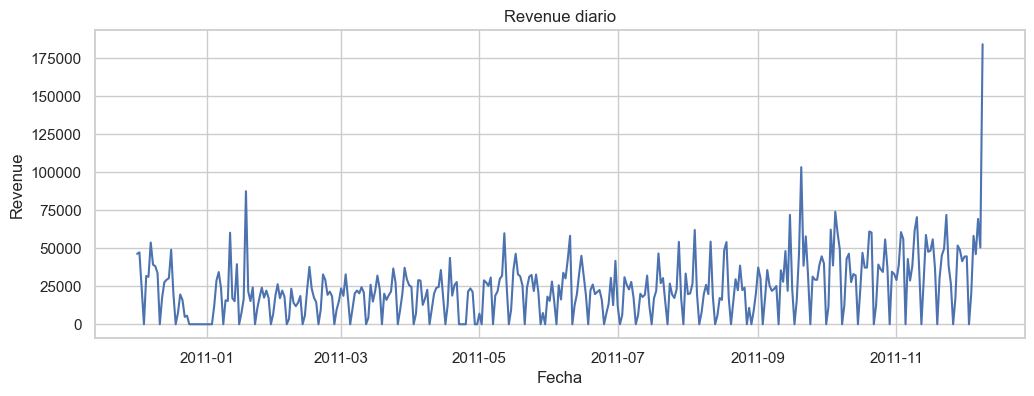

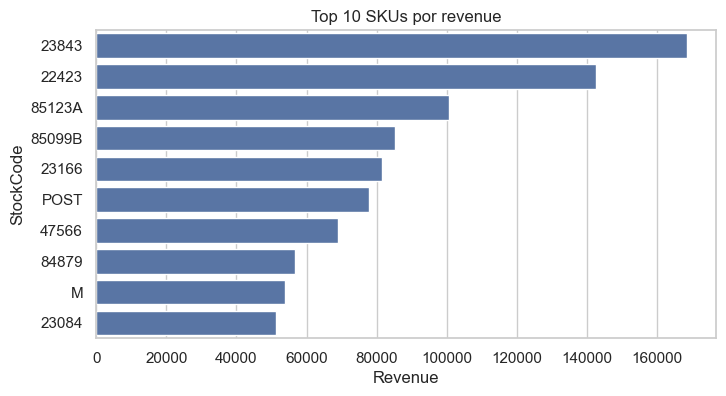

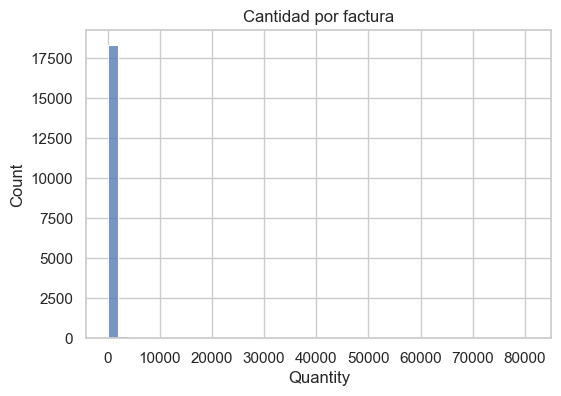

In [ ]:
# 02 - Gráficos básicos (matplotlib / seaborn)

# Serie de ventas diarias
plt.figure(figsize=(12,4))
plt.plot(daily["InvoiceDate"], daily["Revenue"])
plt.title("Revenue diario")
plt.xlabel("Fecha"); plt.ylabel("Revenue")
plt.show()

# Top 10 productos por revenue
top_skus = (df.groupby("StockCode")["Revenue"].sum()
              .sort_values(ascending=False).head(10).reset_index())

plt.figure(figsize=(8,4))
sns.barplot(data=top_skus, x="Revenue", y="StockCode")
plt.title("Top 10 SKUs por revenue")
plt.show()

# Distribución de cantidad por factura
qty_per_invoice = df.groupby("InvoiceNo")["Quantity"].sum()
plt.figure(figsize=(6,4))
sns.histplot(qty_per_invoice, bins=40)
plt.title("Cantidad por factura")
plt.show()

Estrategia de preprocesamiento

Después de realizar la limpieza de la base de datos, asegurando que solo se incluyan clientes con CustomerID y transacciones que clasifiquen como compra, se procederá con: 
1. Orden temporal y tipo de datos: para cada CustomerID se ordenan secuencialmente las transacciones (como una línea de tiempo). Finalmente, se ajusta el tipo de dato de CustomerID a int.
2. RFM - Recencia, Frecuencia y Valor Monetario: mediante esta técnica de segmentación se organizan los clientes en subgrupos para identificar frecuencias y secuencias temporales en sus transacciones, utilizando exclusivamente historial previo a cada evento, evitando fuga de información.
3. Se define la etiqueta y_repurchase_30d: 1 si existe una siguiente compra dentro de 30 días desde la transacción actual; 0 en caso contrario. Se excluyen casos sin ventana de observación completa.
4. Se fijan las features de entrada para el modelo y se excluye la primera transacción de cada cliente.
5.  Se generan splits por fecha (train/valid/test) respetando la secuencia temporal, para evaluar de forma realista el desempeño fuera de muestra.
6. Se implementa un ColumnTransformer con escalado para variables numéricas y One-Hot Encoding para categóricas (p. ej., Country), integrándolo en un Pipeline para asegurar reproducibilidad.

In [34]:
# 01 - Preparar el dataset antes de crear variables históricas por cliente
df.sort_values(['CustomerID', 'InvoiceDate', 'InvoiceNo'], inplace=True) # Ordena el DataFrame por cliente → fecha → factura (sirve como “timeline” por cliente).
df['CustomerID'] = df['CustomerID'].astype(int)

In [35]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.60
14938,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347,Iceland,25.20
14939,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347,Iceland,17.00
14940,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347,Iceland,39.00
14941,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,12347,Iceland,23.40
...,...,...,...,...,...,...,...,...,...
392752,570715,22419,LIPSTICK PEN RED,12,2011-10-12 10:23:00,0.42,18287,United Kingdom,5.04
392753,570715,22866,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12 10:23:00,2.10,18287,United Kingdom,25.20
423939,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28 09:29:00,1.25,18287,United Kingdom,45.00
423940,573167,21824,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28 09:29:00,0.39,18287,United Kingdom,18.72


In [36]:
# 02 - Definir reglas de agrupación para clientes por factura

def historial_compra(g):
    cp_analisis= (g.groupby(['InvoiceNo','InvoiceDate','Country'], as_index=False)
             .agg(Quantity=('Quantity','sum'),
                  Revenue=('Revenue','sum'),
                  UnitPrice=('UnitPrice','mean'))
             .sort_values(['InvoiceDate','InvoiceNo']))
    cp_analisis['CustomerID'] = g.name  # conservar el ID del cliente

    # Features "solo pasado"
    cp_analisis['n_past_invoices'] = np.arange(len(cp_analisis))
    cp_analisis['prev_date']       = cp_analisis['InvoiceDate'].shift(1)
    cp_analisis['recency_days']    = (cp_analisis['InvoiceDate'] - cp_analisis['prev_date']).dt.days.fillna(9999)
    cp_analisis['spend_prior']     = cp_analisis['Revenue'].cumsum() - cp_analisis['Revenue']
    cp_analisis['qty_prior']       = cp_analisis['Quantity'].cumsum()  - cp_analisis['Quantity']
    cp_analisis['avg_ticket_prior']         = np.where(cp_analisis['n_past_invoices']>0, cp_analisis['spend_prior']/cp_analisis['n_past_invoices'], 0.0)
    cp_analisis['avg_qty_per_invoice_prior'] = np.where(cp_analisis['n_past_invoices']>0, cp_analisis['qty_prior']/cp_analisis['n_past_invoices'], 0.0)

    # Label: próxima FACTURA y recompra a 30 días
    cp_analisis['next_date']     = cp_analisis['InvoiceDate'].shift(-1)
    cp_analisis['days_to_next']  = (cp_analisis['next_date'] - cp_analisis['InvoiceDate']).dt.days
    cp_analisis['y_repurchase_30d'] = ((cp_analisis['days_to_next'] <= 30) & (~cp_analisis['next_date'].isna())).astype(int)
    return cp_analisis



In [37]:
cp_analisis= df.groupby('CustomerID', group_keys=False).apply(historial_compra)


In [38]:
# 03 - Límites en las variables de entrada

cutoff = cp_analisis['InvoiceDate'].max() - pd.Timedelta(days=30)
cp_analisis= cp_analisis[(cp_analisis['InvoiceDate'] <= cutoff) & (cp_analisis['n_past_invoices'] > 0)].copy() # Para no predecir el primer registro del cliente (sin historial)

In [39]:
train_end = pd.Timestamp('2011-06-01')
valid_end = pd.Timestamp('2011-09-01')
is_train = cp_analisis['InvoiceDate'] < train_end
is_valid = (cp_analisis['InvoiceDate'] >= train_end) & (cp_analisis['InvoiceDate'] < valid_end)
is_test  = (cp_analisis['InvoiceDate'] >= valid_end) & (cp_analisis['InvoiceDate'] <= cutoff)


In [40]:
# 04 - Selección de variables de entrada
num_feats = [
    'recency_days','n_past_invoices','spend_prior','qty_prior',
    'avg_ticket_prior','avg_qty_per_invoice_prior','UnitPrice','Quantity','Revenue'
]
cat_feats = ['Country']

X = cp_analisis[num_feats + cat_feats].copy()
y = cp_analisis['y_repurchase_30d'].astype(int)
X_train, y_train = X[is_train], y[is_train]
X_valid, y_valid = X[is_valid], y[is_valid]
X_test,  y_test  = X[is_test],  y[is_test]

In [41]:
print("Tamaños (nivel factura):")
for name, m in [('train', is_train), ('valid', is_valid), ('test', is_test)]:
    print(name, m.sum(), "positives:", y.loc[m].mean())

Tamaños (nivel factura):
train 4714 positives: 0.568731438268986
valid 3408 positives: 0.5181924882629108
test 3630 positives: 0.5548209366391185


train 4714 — positives: 0.5687 → Set de entrenamiento tiene 4,714 facturas (después de filtrar y agrupar a nivel factura). El 56.9% de esas facturas sí tienen otra compra dentro de 30 días.

valid 3408 — 0.5182 → En validación, 51.8% son positivas.

test 3630 — 0.5548 → En test, 55.5% son positivas.

Baseline de rendimiento

1. Baseline heurístico (RFM simplificado): predice recompra si recency ≤ 30 y compras previas ≥ 2; sirve como línea base mínima.

2. Modelo Logistic Regression: pipeline con StandardScaler (numéricas) + OneHot (categóricas) y class_weight='balanced'.

3. Validación temporal: se entrena con TRAIN, se calibra umbral en VALID, y reporte de resultados finales en TEST.

4. Métricas: PR-AUC (prioritaria por desbalance), ROC-AUC, F1, precision y recall, más classification_report.

5. Umbral operativo: escogido en VALID y aplicado a TEST para la comparación final.

In [42]:
# 01 - Baseline heurístico (RFM simplificado)

def rfm_rule(X):
    return ((X['recency_days'] <= 30) & (X['n_past_invoices'] >= 2)).astype(int)

# Predicciones
yhat_valid = rfm_rule(X_valid)
yhat_test  = rfm_rule(X_test)

def report(tag, y_true, y_hat):
    acc = accuracy_score(y_true, y_hat)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_hat, average='binary', zero_division=0)
    print(f"{tag} | Acc={acc:.3f}  P={p:.3f}  R={r:.3f}  F1={f1:.3f}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_hat))
    print()

report("RFM VALID", y_valid, yhat_valid)
report("RFM TEST ", y_test,  yhat_test)

print(classification_report(y_test, yhat_test, digits=3))

RFM VALID | Acc=0.712  P=0.724  R=0.717  F1=0.721
Confusion matrix:
 [[1160  482]
 [ 500 1266]]

RFM TEST  | Acc=0.686  P=0.742  R=0.665  F1=0.702
Confusion matrix:
 [[1150  466]
 [ 674 1340]]

              precision    recall  f1-score   support

           0      0.630     0.712     0.669      1616
           1      0.742     0.665     0.702      2014

    accuracy                          0.686      3630
   macro avg      0.686     0.688     0.685      3630
weighted avg      0.692     0.686     0.687      3630



TN=1160 (negativos bien), FP=482 (se predice “recompra” pero no compraron),

FN=500 (se escaparon recompras), TP=1266 (se acierta en recompras).

Precisión y recall ~0.72 (equilibrado).

In [43]:
# 02 - Modelo Logistic Regression

# Pipeline de preprocesamiento

pre = ColumnTransformer([
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats),
])

logreg = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=500))]).fit(X_train, y_train)
vs = logreg.predict_proba(X_valid)[:,1]; ts = logreg.predict_proba(X_test)[:,1]
thr = max(np.linspace(0.1,0.9,9), key=lambda t: f1_score(y_valid, (vs>=t).astype(int)))

def rpt(y_true, scores, thr, tag):
    yhat = (scores>=thr).astype(int)
    p,r,f1,_ = precision_recall_fscore_support(y_true, yhat, average='binary', zero_division=0)
    print(f"{tag} thr={thr:.2f} | PR-AUC={average_precision_score(y_true,scores):.3f} | ROC-AUC={roc_auc_score(y_true,scores):.3f} | F1={f1:.3f} P={p:.3f} R={r:.3f}")

rpt(y_valid, vs, thr, "LogReg VALID")
rpt(y_test,  ts, thr, "LogReg TEST ")

LogReg VALID thr=0.50 | PR-AUC=0.857 | ROC-AUC=0.822 | F1=0.758 P=0.701 R=0.825
LogReg TEST  thr=0.50 | PR-AUC=0.848 | ROC-AUC=0.790 | F1=0.745 P=0.707 R=0.787


VALID: El modelo ordena bien los casos (ROC-AUC>0.8) y, a 0.5, privilegia recall (0.825) sobre precisión (0.701).

TEST: leve caída de VALID→TEST (esperable). Mantiene alto recall con precisión aceptable.

PR-AUC 0.848 está muy por encima de la línea base “no-skill” (~0.55). El modelo recupera muchos positivos con pocas pérdidas de ranking.

Comparado con tu RFM baseline (TEST F1≈0.702, P≈0.742, R≈0.665):

+ Recall: 0.787 vs 0.665 (+12.2 pts).

– Precisión: 0.707 vs 0.742 (–3.5 pts).

+ F1: 0.745 vs 0.702 (+4.3 pts).
En conjunto, mejora clara respecto a la regla.

